# Assignment 2 - CSI4106
Group: assignment_2_49

 Tristan Pender - 300065847 - tpend052@uottawa.ca

 Rafael Villacorta - 300061289 - rvill094@uottawa.ca
 
 Hans Barrea - 300080843 - hbarr050@uottawa.ca

In [28]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5312), started 1 day, 2:39:39 ago. (Use '!kill 5312' to kill it.)

#### Loading the relevant datasets (15/100)

Here is the shape of the train dataset (15026, 4) 

Here is the shape of the test dataset (4696, 4) 

Here is the shape of the val dataset (3757, 4) 

Here are the column names in the dataframe 

age
ethnicity
gender
img_name

 End of the column names. 
Here is the proportional distribution of gender in train 
0    7864
1    7162
Name: gender, dtype: int64 
 ********
Here is the proportional distribution of gender in test 
0    2456
1    2240
Name: gender, dtype: int64 
 ********
Here is the proportional distribution of gender in val 
0    1965
1    1792
Name: gender, dtype: int64 
 ********
Here is the proportional distribution of ethnicity in train 
0.0    6372
1.0    2869
3.0    2524
2.0    2186
4.0    1075
Name: ethnicity, dtype: int64 
 ********
Here is the proportional distribution of ethnicity in test 
0    1991
1     896
3     790
2     683
4     336
Name: ethnicity, dtype: int64 
 ********
Here is the proportional distribution of ethnicity in val 
0    1593
1     717
3     632

<AxesSubplot:ylabel='Frequency'>

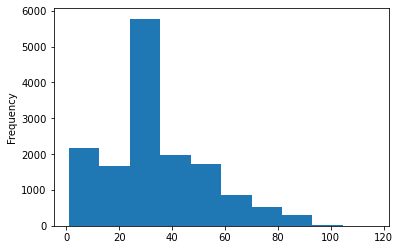

In [29]:
# load the datasets using the csv files train, val and test 
# (3)
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")
val_df = pd.read_csv("./data/val.csv")


# print the shapes of the dataframes 
# (3)
print(f"Here is the shape of the train dataset {train_df.shape} \n")

print(f"Here is the shape of the test dataset {test_df.shape} \n")

print(f"Here is the shape of the val dataset {val_df.shape} \n")



# print the column names from either one of the dataframes 
# (1)
print(f"Here are the column names in the dataframe \n")

for i in train_df.columns : 
    print(i)

print(f"\n End of the column names. ")

train_df["ethnicity"] = np.asarray(train_df["ethnicity"]).astype('float32').reshape((-1,1))
# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
# (3)
train_df_gender_class_distr = train_df['gender'].value_counts()
test_df_gender_class_distr = test_df['gender'].value_counts()
val_df_gender_class_distr = val_df['gender'].value_counts()

print(f"Here is the proportional distribution of gender in train \n{train_df_gender_class_distr} \n ********")
print(f"Here is the proportional distribution of gender in test \n{test_df_gender_class_distr} \n ********")
print(f"Here is the proportional distribution of gender in val \n{val_df_gender_class_distr} \n ********")

# print the proportional distribution of ethnicity in all three datasets 
# (3)
train_df_ethnicity_class_distr = train_df['ethnicity'].value_counts()
test_df_ethnicity_class_distr = test_df['ethnicity'].value_counts()
val_df_ethnicity_class_distr = val_df['ethnicity'].value_counts()
print(f"Here is the proportional distribution of ethnicity in train \n{train_df_ethnicity_class_distr} \n ********")
print(f"Here is the proportional distribution of ethnicity in test \n{test_df_ethnicity_class_distr} \n ********")
print(f"Here is the proportional distribution of ethnicity in val \n{val_df_ethnicity_class_distr} \n ********")

# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are: 
# (2)
train_df.age.plot(kind='hist')


#### Create the ImageDataGenerators (22/100)

Found 15026 validated image filenames.
Found 3757 validated image filenames.
Found 4696 validated image filenames.


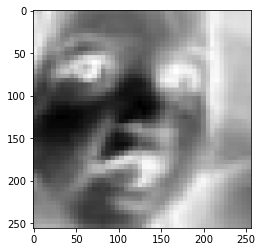

In [30]:
# ImageDataGenerator is an iterator.

# specify the batch size hyperparameter. You can experiment with different batch sizes
batch_size = 16

# create the ImageDataGenerator with rescaling that will generate batched tensors representing images with real-time data augmentation
# use at least two of the augmentation strategies. For example, fill_mode='nearest'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (3)
train_img_gen = ImageDataGenerator(
   fill_mode= "nearest",
   rotation_range=40,
   width_shift_range=0.2,
   height_shift_range=0.2,
   rescale=None
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance to link the image folder and the dataframe.
# also include the, batch size, image size and the seed.
# make sure to include the following arguments
# color_mode='grayscale', class_mode='multi_output'
# please refer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
# (5)
train_flow_from_dataframe = train_img_gen.flow_from_dataframe(
    dataframe=train_df,
    rescale=1./255,
    directory= "./data/images/train/",
    x_col= "img_name",
    y_col= ["age","ethnicity","gender"],
    color_mode= "grayscale",
    class_mode="multi_output",
    seed=SEED,
    target_size=(256, 256),

    batch_size=batch_size,
)

# similarly, create an ImageDataGenerator for the validation dataset and make sure not to use any of th eaugmentation strategies except rescaling the image
# (2)
val_img_gen = ImageDataGenerator(
    rescale= None
)

# use the method "flow_from_dataframe" from the "ImageDataGenerator" instance with the same arguments as above
# make sure to specify the following arguments:
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)

val_flow_from_dataframe = val_img_gen.flow_from_dataframe(
    dataframe=val_df,
    rescale=1./255,
    directory= "./data/images/val/",
    x_col= "img_name",
    y_col= ["age","ethnicity","gender"],
    color_mode= "grayscale",
    class_mode="multi_output",
    seed=SEED,
    batch_size=batch_size,
    target_size=(256, 256),

    shuffle=False    
)

# use the method "flow_from_dataframe" from the val_img_gen instance to link the test dataframe and the test data folder
# In addition, make sure to specify the following arguments
# class_mode='multi_output', color_mode='grayscale', shuffle=False
# (5)
test_generator = val_img_gen.flow_from_dataframe(
    dataframe=test_df,
    directory= "./data/images/test/",
    x_col= "img_name",
    rescale=1./255,
    y_col= ["age","ethnicity","gender"],
    color_mode= "grayscale",
    class_mode="multi_output",
    seed=SEED,
    batch_size=batch_size,
    target_size=(256, 256),

    shuffle=False    
)


# enumerate through the validation data generator created above and plot first grayscale image 
# (2)
# generate samples and plot

plt.plot(figsize=(15,15))



for i, element in enumerate(val_flow_from_dataframe):
    image = element[0].astype('uint8')
    # plot image
    plt.plot()
    img_plot = plt.imshow(image[0], cmap=plt.cm.binary)
    plt.show()
    
    break


#### Create the model (44/100)

In [75]:
# specify the model input with the required shape 
# (1)
inputs = keras.Input(shape=(256,256,1)) 

# The shared layers
# Include at least one Conv2D layer, MaxPooling2D layer and a Flatten layer
# you can have as many layers as possible, but make sure not to overfit your model using the training data
x = layers.Conv2D(filters=32, kernel_size=2, activation="relu")(inputs) 
x = layers.MaxPooling2D(pool_size=2)(x) 
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)  
x = layers.MaxPooling2D(pool_size=3)(x)  
x = layers.Dense(64, activation='relu', name='dense1')(x) 
x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)  
x = layers.Dense(128, activation='relu', name='dense2')(x)
x = layers.Dense(128, activation='relu', name='dense3')(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu', name='dense4')(x)
x = layers.Dense(128, activation='relu', name='dense5')(x)
# (10)


# Task specific layers
# Include at least one Dense layer as a task specific layer before generating the output for age
age_dense_layer = layers.Dense(512, activation='relu', name='dense_age1')(x)
age_dense_layer = layers.Dense(256, activation='relu', name='dense_age2')(age_dense_layer)
age_dense_layer = layers.Dense(256, activation='relu', name='dense_age3')(age_dense_layer)
age_dense_layer = layers.Dense(128, activation='relu', name='dense_age4')(age_dense_layer)
age_dense_layer = layers.Dense(64, activation='relu', name='dense_age5')(age_dense_layer)
# (2)
# Include the age output and make sure to include the following arguments
# activation='linear', name='xxx'(any name)
# make sure to name your output layers so that different metrics to be used can be linked accordingly
# please note that the age prediction is a regression task
age_output = layers.Dense(1, activation='linear', name='age_output')(age_dense_layer)
# (2)


# Similar to above, specify one or more Dense layers as task specific layers for ethnicity prediction
ethnicity_dense_layer = layers.Dense(512, activation='relu', name='dense_ethinicity1')(x)
ethnicity_dense_layer = layers.Dense(512, activation='relu', name='dense_ethinicity2')(ethnicity_dense_layer)
ethnicity_dense_layer = layers.Dense(256, activation='relu', name='dense_ethinicity3')(ethnicity_dense_layer)
ethnicity_dense_layer = layers.Dense(128, activation='relu', name='dense_ethinicity4')(ethnicity_dense_layer)
ethnicity_dense_layer = layers.Dense(128, activation='relu', name='dense_ethinicity5')(ethnicity_dense_layer)
# (2)
# Include the ethnicity output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a multi-class classification task
ethnicity_output = layers.Dense(5, activation='softmax',kernel_initializer='constant', name='ethnicity_output')(ethnicity_dense_layer)
# (2)


# Similar to above, specify one or more Dense layers as task specific layers for gender prediction
gender_dense_layer = layers.Dense(512, activation='relu', name='dense_gender1')(x)
gender_dense_layer = layers.Dense(256, activation='relu', name='dense_gender2')(gender_dense_layer)
gender_dense_layer = layers.Dense(256, activation='relu', name='dense_gender3')(gender_dense_layer)
gender_dense_layer = layers.Dense(128, activation='relu', name='dense_gender4')(gender_dense_layer)
gender_dense_layer = layers.Dense(64, activation='relu', name='dense_gender5')(gender_dense_layer)
# (2)
# Include the gender output that uses the task specific output from the layer above
# please note that the ethnicity prediction is a binary classification task
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(gender_dense_layer)
# (2)


# create the model with the required input and the outputs.
# pelase make sure that the outputs can be included in a list and make sure to keep note of the order
model = keras.models.Model(inputs=inputs, outputs=[age_output, ethnicity_output, gender_output])
# (3)

# print the model summary
model.summary()
# (0.5)

# Instantiate the optimizer with the learning rate. You can start with the learning rate 1e-3(0.001).
# Both the optimizer and the learning rate are hyperparameters that you can finetune
# For example, you can start with the "RMSprop" optimizer
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)
# (2)

# specify the losses to be used for each task: age, ethnicity and gender prediction 
# (0.5)
losses = ["mean_squared_error","sparse_categorical_crossentropy",'binary_crossentropy']
# compile the model with the optimizer, loss, loss_weights and the metrics for each task
# apply the following weights to the losses to balance the contribution of each loss to the total loss
# please remember to use the relevant metric for each task by assigning it to the correct output
loss_weights=[0.001, 0.1, 0.5]
model.compile(optimizer = optimizer, loss=losses, loss_weights= loss_weights, metrics=['mean_squared_error', 'accuracy'])
# (2)

# Define the callbacks
# EarlyStopping: monitor the validation loss while waiting for 3 epochs before stopping
# can restore the best weights
# (2)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ModelCheckpoint
# monitor validation loss and save the best model weights
# (2)
checkpoints = keras.callbacks.ModelCheckpoint(
    filepath = "./models",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False
)

# Initiallize TensorBoard
# (2)
# For if the line below breaks everything: tf.profiler.experimental.stop()
tensorboard = keras.callbacks.TensorBoard(log_dir= "./logs")
# ReduceLROnPlateau
# reduce the learning rate by a factor of 0.1 after waiting for 2 epochs while monitoring validation loss
# specify a minimum learning rate to be used
# (2)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.0001
)

# fit the model with training and validation generators
# In addition please specify the following arguments
steps_per_epoch=len(train_df)/batch_size
validation_steps=len(val_df)/batch_size
# (5)
model.fit_generator(
    train_flow_from_dataframe, 
    epochs = 5,
    validation_data = val_flow_from_dataframe, 
    steps_per_epoch=len(train_df)/batch_size,
    validation_steps=len(val_df)/batch_size,
    callbacks=[reduce_lr, early_stop, checkpoints, tensorboard],
)


Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 255, 255, 32) 160         input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 127, 127, 32) 0           conv2d_18[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 125, 125, 64) 18496       max_pooling2d_12[0][0]           
_______________________________________________________________________________________

#### Making predictions on test data (14/100)

In [76]:
# evaluate the trained model using the test generator
# print only the test accuracy for ethnicity and gender predictions
(4)
scores = model.evaluate(test_generator)

print(f"Ethnicity test accuracy is {scores[7]} \n")
print(f"Gender test accuracy is {scores[9]} \n")


294/294 [==============================] - 60s 205ms/step - loss: 0.6443 - age_output_loss: 244.9373 - ethnicity_output_loss: 1.3046 - gender_output_loss: 0.5379 - age_output_mean_squared_error: 244.9373 - age_output_accuracy: 0.0492 - ethnicity_output_mean_squared_error: 2.9831 - ethnicity_output_accuracy: 0.4757 - gender_output_mean_squared_error: 0.1796 - gender_output_accuracy: 0.7323
Ethnicity test accuracy is 0.4757240116596222 

Gender test accuracy is 0.7323253750801086 



In [77]:
# generate predictions using the test generator
# (2)
age_pred, ethnicity_pred, gender_pred = model.predict(test_generator)

In [79]:
# extract the ethnicity predictions
# (2)
test_lbls_ethnicity = test_generator.labels[1]
pred_lbls_ethnicity = np.argmax(ethnicity_pred, axis=1)

# print the classification report for predicting ethnicity
# (2)
cr_ethnicity = classification_report(test_lbls_ethnicity, pred_lbls_ethnicity)
print(cr_ethnicity)

# extract the gender predictions where probabilities above 0.5 are considered class 1 and if not, class 0
# (2)
test_lbls_gender = test_generator.labels[2]
gender_pred_binary = (gender_pred > 0.5).astype(int)

# print the classification report for predicting gender
#(2)
cr_gender_binary = classification_report(test_lbls_gender, gender_pred_binary)
print(cr_gender_binary)


              precision    recall  f1-score   support

           0       0.46      0.93      0.62      1991
           1       0.60      0.28      0.38       896
           2       0.53      0.19      0.28       683
           3       0.00      0.00      0.00       790
           4       0.00      0.00      0.00       336

    accuracy                           0.48      4696
   macro avg       0.32      0.28      0.25      4696
weighted avg       0.39      0.48      0.37      4696

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      2456
           1       0.79      0.59      0.68      2240

    accuracy                           0.73      4696
   macro avg       0.75      0.73      0.72      4696
weighted avg       0.74      0.73      0.73      4696



C:\Users\RAF\miniconda3\envs\A1\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAF\miniconda3\envs\A1\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\RAF\miniconda3\envs\A1\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Present prediction results on test data(5/100)

Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.


| Hyperparameters                                                                                                        | Age(MAE) | Ethnicity(Accuracy) | Gender(Accuracy) |
|------------------------------------------------------------------------------------------------------------------------|----------|---------------------|------------------|
| batch_size = 16, epochs = 5, early_stop patience = 5, reduce_lr patience = 5, checkpoints save_best_only = True        | 245.0447 | 0.4818              | 0.7378           |
| batch_size = 128, epoch = 4, early_stop patience = 3, reduce_lr patience = 2, checkpoint save_weights = False          | 420.0009 | 0.4240              | 0.5832           |
| batch_size = 16, epochs = 5, early_stop patience = 5, early_stop restore_best_weights = True, reduce_lr min_lr 0.0001  | 309.2747 | 0.4533              | 0.6884           |
| batch_size = 8, epochs = 3, early_stop patience = 3, reduce_lr min_lr = 0.00001, checkpoints save_weights_only = False | 443.5240 | 0.4253              | 0.6039           |
| batch_size = 16, epochs = 1, early_stop patience = 3, reduce_lr factor = 0.01, reduce_lr patience = 2                  | 408.8803 | 0.4240              | 0.5230           |